# Custom models and its evaluation

This practice purposed to cover 3 technical topics using theoretical framework, you met on lections, but not only.

These topics are:

1.   Custom goal function and its optimization (using MAPE as example).
2.   Preprocessing pipelines (using polynomial features as example).
3.   Hyper-parameters tuning using Cross-validation.

All examples are made with the same artificial regression data. I encourage you to try it on your dataset and also classification task!


### Possible tasks

0. Make your own implementation of Cross-Validation procedure.
1. Implement L1 and L2 (or Lp) regularization for polynomial regression and use Cross-Validation to find optimal regularization method and coefficient 
2. Use regularization for to reduce number of features in polynomial regression 
3. Implement your own loss and objective function 
4. Implement weighted linear regression and use cross-validation to find optimal $\sigma$ parameter
5. Remade the whole document to solve classification task 

Any experiments will be appreciated and evaluated.

In [1]:
import numpy as np
from sklearn import datasets
import pandas as pd
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [20,8]

## Get data

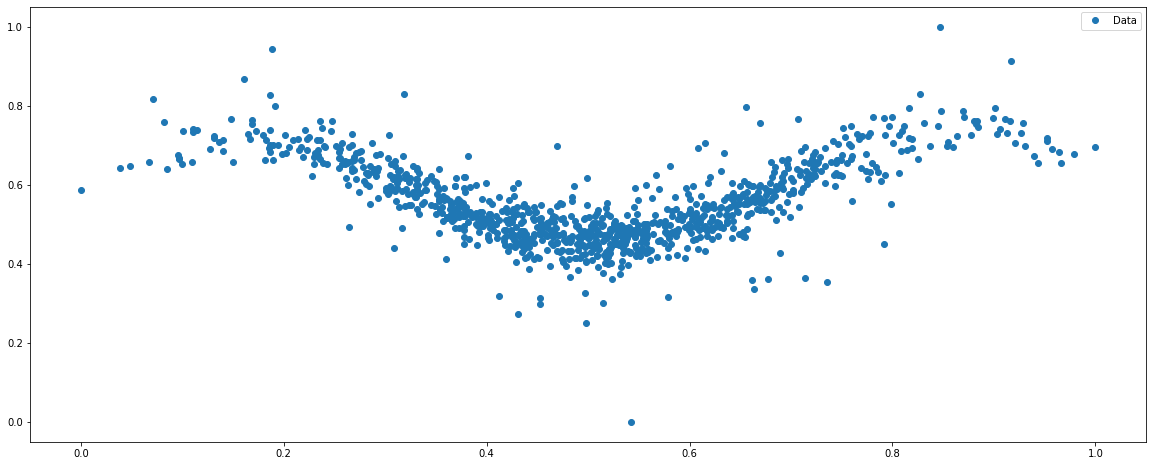

In [3]:
# Generate nonlinear data with outliers.

n_samples = 1000
n_outliers = 100

X, y = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=25,
                                      coef=False, random_state=1110)



# Replace first N samples with outliers

X[:n_outliers] = np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = 100 * np.random.normal(size=n_outliers)

# Add non-linearity to data

y = y+100*X.T[0]*np.sin(X.T[0])

# Scale data to put in range [0,1] for stability.
# Check results if ignore it.
# See also sklearn User Guide (https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range) and try another tools (Standartization, Normalization)
X = (X - X.min())/(X.max()-X.min())
y = (y - y.min())/(y.max()-y.min())


plt.plot(X, y, 'o', label = 'Data')
plt.legend()

In [4]:
# Add bias column to data
X_I = np.c_[np.ones_like(X), X]

## Define Model

My loss fucntions have the same structure: 

def mape(y_true,  y_pred, X, x_i, theta, alpha)\
def ridge(y_true, y_pred, X, x_i, theta, alpha)\
def lasso(y_true, y_pred, X, x_i, theta, alpha)\
def ridge(y_true, y_pred, X, x_i, theta, alpha)\
def logistic_regression(y_true, y_pred, theta, alpha)\
def locally_weighted(y_true, y_pred, X, x_i, theta, sigma)
                                           
Lasso and Ridge loss fucntions use parameter theta and alpha for sum 
$$\frac{\alpha}{2}\sum_i\theta_i^2$$ - for ridge
$$\alpha\sum_i |\theta_i|$$ - for lasso

Locally weighted regression use parameter x_i for function w(X, x_i, sigma) what calculate
$$\omega^{(i)} = \text{exp}\left(  - \frac{(x^{(i)} - x)^2}{2\sigma^2}\right)$$
                                           
                                            

### Mean Absolute Percentage Error (MAPE)

Let's use [Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) as a custom error function:

$$ \text{MAPE} = \frac{1}{n}\sum_i \left| \frac{y_i - \hat{y_i}}{y_i} \right| \cdot 100\%$$

This function uses percentage ratio between error and original value to express forecast accuracy, which is much more interpretable, than absolute error. 

You can try your loss function here! Figure out something or google anything like 'Best regression loss function'. The only what matters is to take y_true and y_pred on input and return single value.

In [8]:
def mape(y_true, y_pred, X=None, x_i=None, theta=None, alpha=None):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    #print(y_true)
    #print(y_pred)
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal"
    
    if np.any(y_true==0):
        #print("Found zeroes in y_true. MAPE is undefined. Removing it from set.")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        #print("%i samples deleted" %len(idx))
    
    mape_value = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape_value

In [9]:
def predict(X, theta, train_x=None):
    return np.dot(X, theta)

In [10]:
print('Error of random model: %.2f%%'%mape(y, predict(X_I, theta = np.random.random(len(X_I[0])))))

Error of random model: 49.61%


Define objective (goal) function as simple as
$L(\theta|X,y) = MAPE(y, h(\theta|X))$

To make it compatible with optimization procedure, put optimizied parameter _theta_ on the first place in arguments. 

Objective function has parameters x_i and alpha for loss functions

In [15]:
def objective_function(theta, X, y, x_i=None, loss_function=mape, alpha=None):
  y_true = np.asanyarray(y)
  y_pred = predict(X, theta)
  #print(X)
  #print(theta)
  
  return loss_function(y_true, y_pred, X, x_i, theta, alpha)

Visualize objective function surface

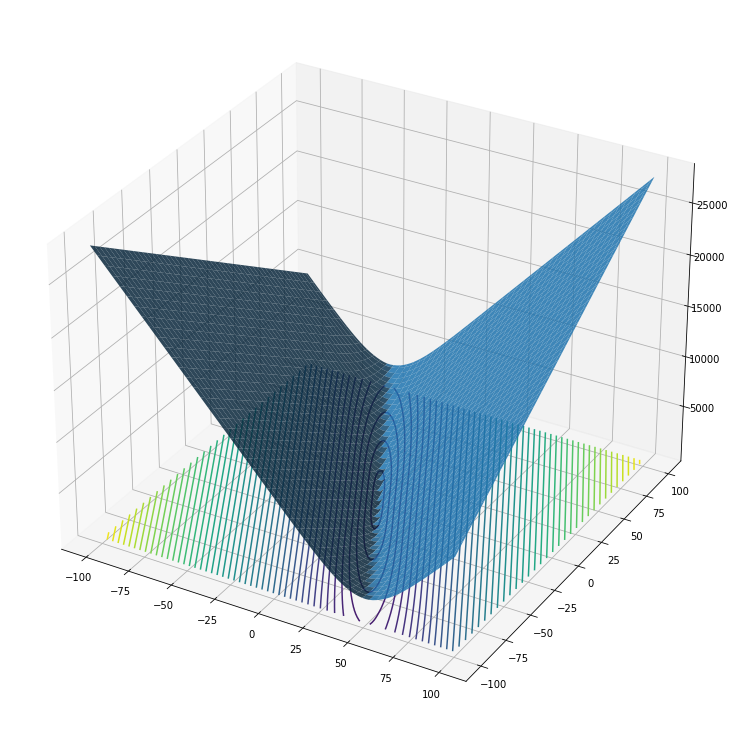

In [16]:
size = 100 # amount of tries for each parameter
limits = (-100,100) # range of values for each parameter
error = np.zeros((size,size)) # empty matrix of errors
for i,w in enumerate(np.linspace(*limits,size)): # for each theta[0] component
    for j,b in enumerate(np.linspace(*limits,size)): # for each theate[1] component
        error[i,j] = objective_function(theta=np.array([b,w]), X=X_I, y=y, loss_function=mape) # compute cost for each theta

# initialize figure
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)

# create 2d array for each index 
K,L = np.meshgrid(np.linspace(*limits,size),np.linspace(*limits,size))

ax.plot_surface(K,L,Z = error, alpha = 0.85) # plot cost function surface in 3d
plt.contour(K,L,error,50, offset = 1) # plot cost function 2d-projection

## Train model

We're done with defining gradient descent step manually!

There are less efficient but more universal approaches, for example use numerical optimization methods. 

Let's try [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html).

In [17]:
from scipy import optimize

In [18]:
theta_init = np.array([1]*X_I.shape[1]) # initial value of theta

result = optimize.minimize(
                           objective_function,  # function to optimize. Parameter to optimize should the first argument 
                           args=(X_I, y, mape), # other arguments of the function
                           x0 = theta_init,     # initial value of parameter to optimize
                           method='Powell',     # optimization method. Try also BFGS, Nelder-Mead, Powell, CG, TNC and others (see docs). Effectivnes can change dramatically!
                           options={}           # arguments of optimization method, like number of iterations, learning rate, etc.
                           )

In [19]:
result

   direc: array([[ 1.        ,  0.        ],
       [ 0.53666754, -0.9338478 ]])
     fun: 14.288736194235108
 message: 'Optimization terminated successfully.'
    nfev: 112
     nit: 3
  status: 0
 success: True
       x: array([ 0.52771124, -0.0258129 ])

Optimization results come in the special object. Here what we are interested in:

In [20]:
print('Optimization result:', ['FAIL','Success'][result.success])
print('Comment:', result.message)
print('Objective function value:', result.fun)
print('Found theta:', result.x)

Optimization result: Success
Comment: Optimization terminated successfully.
Objective function value: 14.288736194235108
Found theta: [ 0.52771124 -0.0258129 ]


The most common reason of optimization fail is _'Desired error not necessarily achieved due to precision loss'_. It means, that on some point the procedure became numerically unstable, usually because of too big or too small values of objective function. 

If this point wasn't too close, results are still usable. 

There is also some chance to make result better with changing _theta_init_  or just re-running the function, and, the most reliable, change optimization method's options and method itself.

Also normalizing data is always useful.

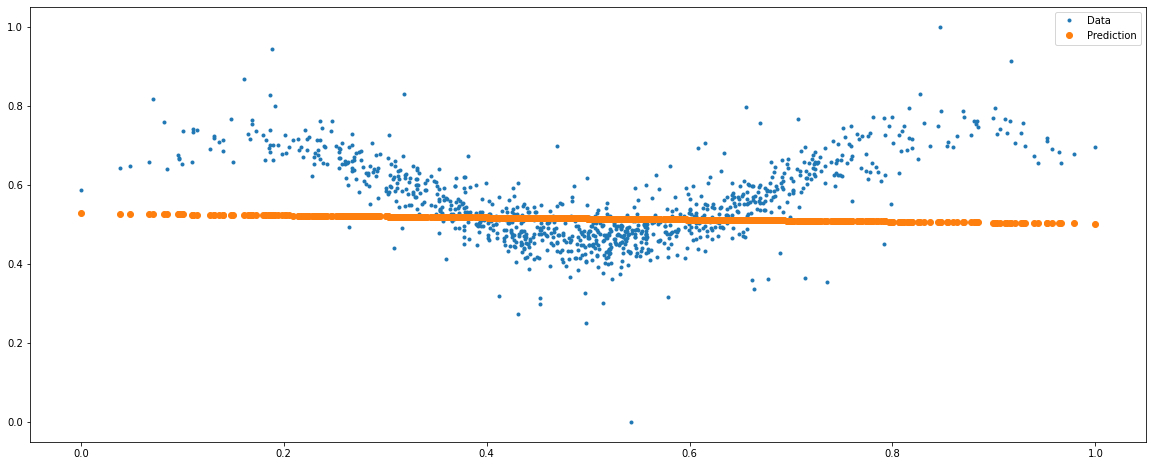

In [21]:
# Visualize result
theta = result.x
y_pred = predict(X_I, theta)
plt.plot(X, y, '.', label = 'Data')
plt.plot(X, y_pred, 'o', label = 'Prediction')
plt.legend()

In [22]:
# For further use, let's make universal function to train regression model with any objective and loss functions

def custom_regression(X, y, x_i=None,
                      objective_function=objective_function, 
                      loss_function=mape, 
                      init = 1, 
                      verbose = True, 
                      iters = 10,
                      method='BFGS',
                      alpha = None):
  
  theta_init = np.ones_like(X[0]) * init
  result = optimize.minimize(objective_function,
                             args=(X, y, x_i, loss_function, alpha), 
                             x0 = theta_init, 
                             method=method, 
                             options={'maxiter': iters})
  theta = result['x']
  if verbose:
    print(result['fun'])
  return theta

## Add polynomial features

In [23]:
from sklearn.preprocessing import PolynomialFeatures

n = 10 # power of polynom
polynomial_features = PolynomialFeatures(degree=n,include_bias=True) # create instance of preprocessor
X_a = polynomial_features.fit_transform(X) # apply transformation
X_a.shape

(1000, 11)

In [24]:
theta = custom_regression(X_a, y, objective_function=objective_function, loss_function=mape)

7.676043197586351


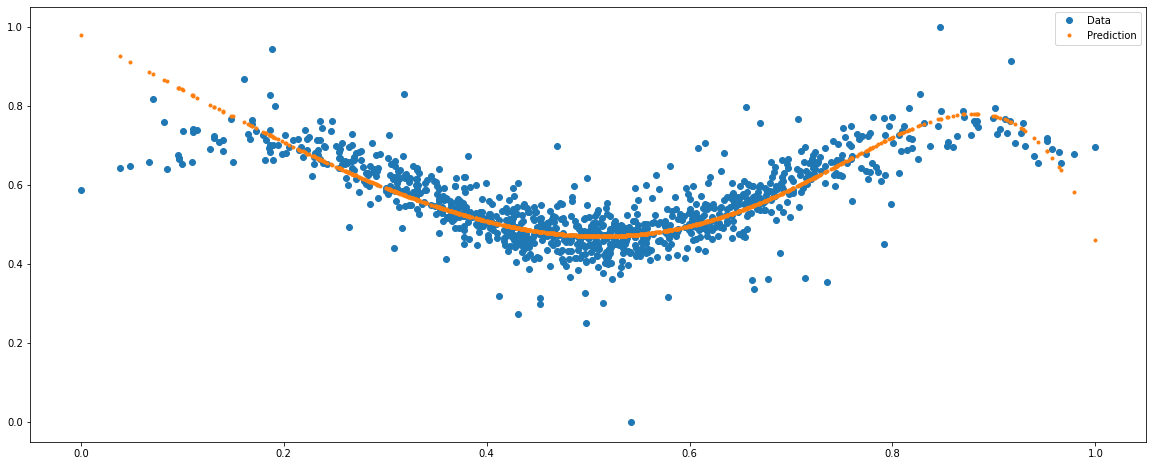

In [25]:
y_pred = predict(X_a, theta)
plt.plot(X, y, 'o', label = 'Data')
ax = plt.gca()
ax.autoscale(enable = True)
plt.plot(X, y_pred, '.', label = 'Prediction')
plt.legend()

In [26]:
degrees = [1,2,5,10,25,50,500]

In [27]:
from sklearn.model_selection import train_test_split

# Split data to test and train in sklearn style
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

14.37271612069135
8.70605273240635
6.886043600745085
7.220521045073543
7.11540314588319
7.24089379190244
7.365202664142304
Wall time: 14.3 s


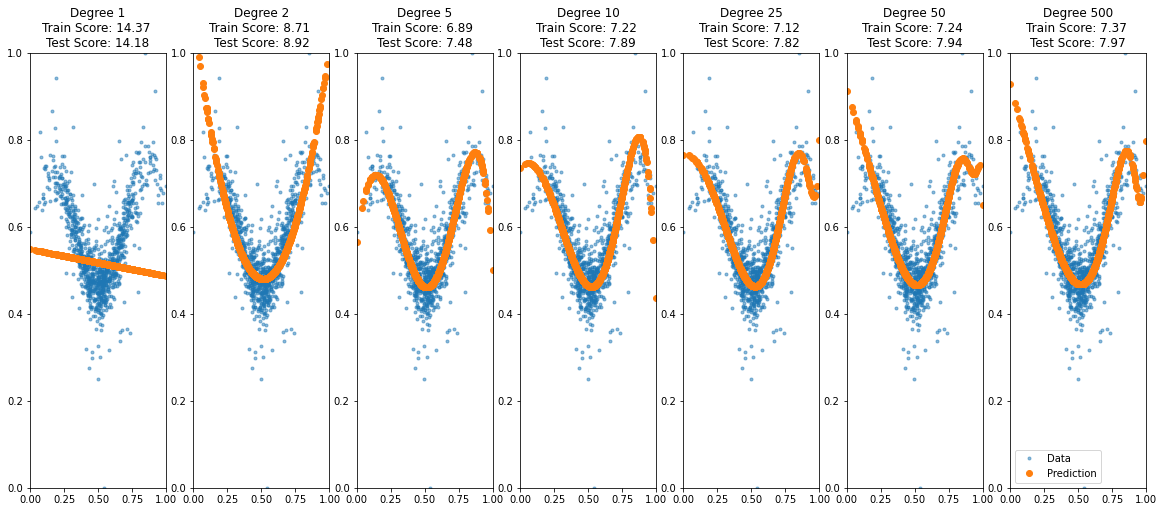

In [28]:
%%time
for i,n in enumerate(degrees):
  polynomial_features = PolynomialFeatures(degree=n,include_bias=True)
  
  # make transformation of all data subsets
  X_all = polynomial_features.fit_transform(X)
  X_a_train = polynomial_features.fit_transform(X_train)
  X_a_test = polynomial_features.fit_transform(X_test)
  
  # train model
  theta = custom_regression(X_a_train, y_train, objective_function=objective_function, loss_function=mape, iters = 20)
  
  # test model
  y_pred_test = predict(X_a_test, theta)
  y_pred_train = predict(X_a_train, theta)
  test_score = objective_function(theta=theta, X=X_a_test, y=y_test)
  train_score = objective_function(theta=theta, X=X_a_train, y=y_train)
  
  #visualize results
  y_pred = predict(X_all, theta)
  
  ax = plt.subplot(1, len(degrees), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(X, y_pred, 'o', label = 'Prediction')
  plt.title("Degree %i\nTrain Score: %.2f \nTest Score: %.2f"%(degrees[i], train_score, test_score))
plt.legend()

## Evaluate result

To make convenient and safe using of our approach (preprocessing + modelling) we can use great sklearn tool called [Pipelines](https://scikit-learn.org/stable/modules/compose.html#pipelines-and-composite-estimators).

Pipeline can include any number of data transformations and modelling, and than be treated as a single sklearn object.

To make it possible, all models of sklearn inherits the same interface, which essentialy should have just few methods:
* ```__init__()```, that should be able to be called without arguments and create an instance with no dependencies to data.
* ```fit()```, that takes data and make all data-dependent actions (transformations or training). Main logic is here. 
* ```predict()``` (for models) or ```transform()``` (for preprocessing) to process a new data after fitted

Optionally, we can use ```score()``` which take true data and return single value to evaluate quality of the model. It is used to make cross-validation and other model selection procedures.

Finally, methods ```fit_transform()``` or ```fit_predict()``` are not essential, but commonly used and just make fit and transform (or predict) on the same data data in one step.




In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin 

Sklearn has one basic class ```BaseEstimator``` for all objects and few inherited specials for particular tasks, like ```ClassifierMixin```, ```RegressorMixin``` and ```TransformerMixin```. Inheriting them we can be sure that we have all non-essential but useful methods, like ```set_value```, ```get_value``` etc, and also tell Pipelines how to treat our object.

In [38]:
def fit(X, y, objective_function=objective_function, loss_function=mape,  #I define fit like separate function because
        theta=None, iters=20, init=1, method='L-BFGS-B', alpha=None):     #for fitting locally weighted regression this 
    if type(theta) == type(None):                                         #function has another realization
      theta = np.ones_like(X[0]) * init
    else:
      assert theta.shape == X[0].shape, "Model's shape doesn't fit input shape"
    theta = custom_regression(X, y, objective_function=objective_function, loss_function=loss_function, 
                                   init = theta, verbose = False, iters=iters, 
                                   method=method, alpha=alpha)
    return theta

In [132]:
def score(theta, X,y,loss_function, alpha, train_x=None):
    return objective_function(theta=theta, X=X,y=y,loss_function=loss_function, alpha=alpha)

In [133]:
class CustomRegression(BaseEstimator, RegressorMixin):                           
  def __init__(self, loss_function=mape, objective_function=objective_function, 
               alpha=None, theta_init=None, init = 1, iters = 20, method='L-BFGS-B'): # all arguments should have default values
    self.theta = theta_init # we don't know shape of theta on this stage
    # just save all variables taken during call to internal variables
    self.loss_function = loss_function 
    self.objective_function = objective_function
    self.alpha = alpha                             #reguralization parameter 
    self.iters = iters                             #number of iterations for optimize 
    self.method = method                           #method for optimize
    self.init = init                               #initial points for optimize
    self.x_what_was_used_for_training = None       #I use it for predictions for locally weighted regression 
    
  def predict(self, X):
    return predict(X, self.theta, self.x_what_was_used_for_training)
  
  def score(self, X, y):
    #return self.objective_function(theta=self.theta, X=X,y=y,loss_function=self.loss_function, alpha=self.alpha)
    return score(theta=self.theta, X=X,y=y,loss_function=self.loss_function, 
                 alpha=self.alpha, train_x=self.x_what_was_used_for_training)
  
  def fit(self, X, y):
    #print(self.loss_function)
    self.x_what_was_used_for_training = X
    self.theta = fit(X, y, self.objective_function, self.loss_function, 
                     theta = self.theta, iters=self.iters, init=self.init,
                     method=self.method, alpha=self.alpha)
    #return self.score(X, y)
  
  def fit_predict(self, X, y):
    self.fit(X,y)
    return self.predict(X)
     

Use the class with Pipeline

Wall time: 2min 14s


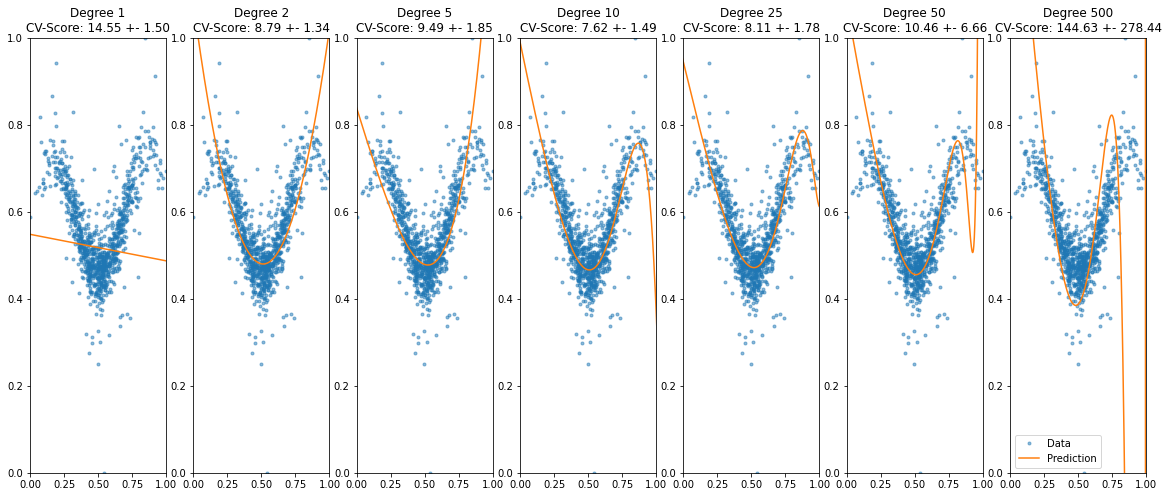

In [42]:
%%time
results = {}
row_results = {}
for i,n in enumerate(degrees):
  polynomial_features = PolynomialFeatures(degree = n) # create instance of transformer
  regression = CustomRegression(loss_function=mape) # create instance of model

  # make pipeline as list of pairs (<stage name>, <stage object>):
  pipeline = Pipeline([("polynomial_features", polynomial_features), # augment data
                       ("linear_regression", regression)]) # apply linear regression
  
  # from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
  pipeline.fit(X_train, y_train)

  # Evaluate pipeline using crossvalidation and score() method
  scores = cross_val_score(pipeline, X_train, y_train, cv=10)
  
  # Make single evaluation on test set
  #test_scores = pipeline.score(X_test, y_test)

  # Save results
  results[n] = {'CV_mean':scores.mean(), 'CV_std':scores.std()} #, 'Test':test_scores
  row_results[n] = scores

  # Plot results
  line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
  line_y = pipeline.predict(line_x)
  
  ax = plt.subplot(1, len(degrees), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(line_x, line_y, '-', label = 'Prediction')
  plt.title("Degree %i\nCV-Score: %.2f +- %.2f"%(n, 
                                                 results[n]['CV_mean'],
                                                 results[n]['CV_std']))
  
plt.legend()

In [43]:
# simple way to see best runs
results = pd.DataFrame(results).T
results.style.highlight_min()

,CV_mean,CV_std
1,14.5473,1.50179
2,8.78569,1.34137
5,9.48831,1.84571
10,7.61804,1.48677
25,8.11296,1.77534
50,10.4612,6.66339
500,144.633,278.436


<AxesSubplot:>

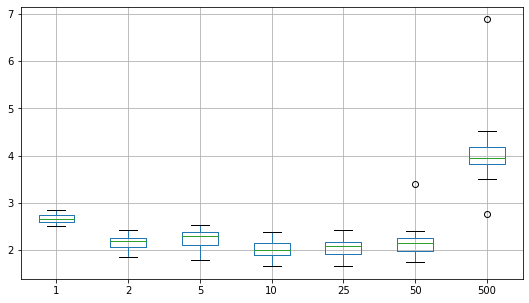

In [44]:
# simple way to visualize model's quality and stability
# using log because of possibly huge outliers on high degrees. Remove it, if everything is  ok.
pd.DataFrame(row_results).apply(np.log).boxplot(figsize = (9,5))

Analyze results and describe proper way to chose model (be carefull, there is intentional error in the last procedure with cross-validation)

CV shows us that polinomial of 10 order is the best aproximation\
but on plot we can that estimations for 2, 5, 10 and 25 order polinomial don't differ a lot  

## 0. Make your own implementation of Cross-Validation procedure.

In [45]:
from sklearn.model_selection import KFold

In [46]:
def my_cross_validate(model, X, Y, cv=10):
    #beta_init = None

    # Split data into training/holdout sets
    kf = KFold(n_splits=cv, shuffle=True)
    kf.get_n_splits(X)

    # Keep track of the error for each holdout fold
    k_fold_scores = []

    # Iterate over folds, using k-1 folds for training
    # and the k-th fold for validation
    f = 1
    for train_index, test_index in kf.split(X):
        # Training data
        CV_X = X[train_index,:]
        CV_Y = Y[train_index]
        CV_weights = None

        # Holdout data
        holdout_X = X[test_index,:]
        holdout_Y = Y[test_index]
        holdout_weights = None

        # Fit model to training sample
        model.fit(CV_X, CV_Y)
        
        fold_score = model.score(holdout_X, holdout_Y)
        k_fold_scores.append(fold_score)
        f += 1

    return np.array(k_fold_scores)

In [47]:
plt.rcParams['figure.figsize'] = [20,8]

Wall time: 1min 48s


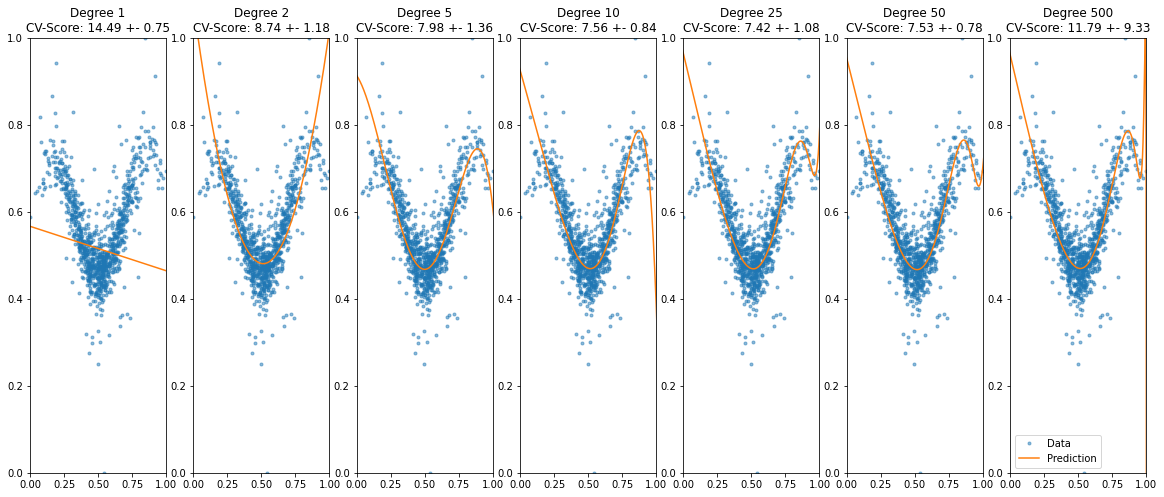

In [48]:
%%time
results = {}
row_results = {}

for i,n in enumerate(degrees):
  polynomial_features = PolynomialFeatures(degree = n) # create instance of transformer
  regression = CustomRegression() # create instance of model

  # make pipeline as list of pairs (<stage name>, <stage object>):
  pipeline = Pipeline([("polynomial_features", polynomial_features), # augment data
                       ("linear_regression", regression)]) # apply linear regression
  
  # from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
  pipeline.fit(X_train, y_train)

  # Evaluate pipeline using crossvalidation and score() method
  scores = my_cross_validate(pipeline, X_train, y_train, cv=10)
  
  # Make single evaluation on test set
  #test_scores = pipeline.score(X_test, y_test)

  # Save results
  results[n] = {'CV_mean':scores.mean(), 'CV_std':scores.std()} #, 'Test':test_scores
  row_results[n] = scores

  # Plot results
  line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
  line_y = pipeline.predict(line_x)
  
  ax = plt.subplot(1, len(degrees), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(line_x, line_y, '-', label = 'Prediction')
  plt.title("Degree %i\nCV-Score: %.2f +- %.2f"%(n, 
                                                 results[n]['CV_mean'],
                                                 results[n]['CV_std']))
  
plt.legend()

In [49]:
# simple way to see best runs
results = pd.DataFrame(results).T
results.style.highlight_min()

,CV_mean,CV_std
1,14.4921,0.751316
2,8.74108,1.17731
5,7.97901,1.3573
10,7.55746,0.844869
25,7.42173,1.07778
50,7.53332,0.784649
500,11.7871,9.3312


## 1. Implement L1 and L2 (or Lp) regularization for polynomial regression and use Cross-Validation to find optimal regularization method and coefficient 

### L2 regularization

In [53]:
#Define loss function for L2 
def ridge(y_true, y_pred, X, x_i, theta, alpha):
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal" 
    return np.mean((y_true - y_pred)**2)/2 + alpha/2*np.sum(theta*theta)

In [51]:
#Create array for models
n = 50
polynomial_features = PolynomialFeatures(degree=n,include_bias=True) 
  
# make transformation of all data subsets
X_all = polynomial_features.fit_transform(X)
X_a_train = polynomial_features.fit_transform(X_train)
X_a_test = polynomial_features.fit_transform(X_test)

Wall time: 36.4 s


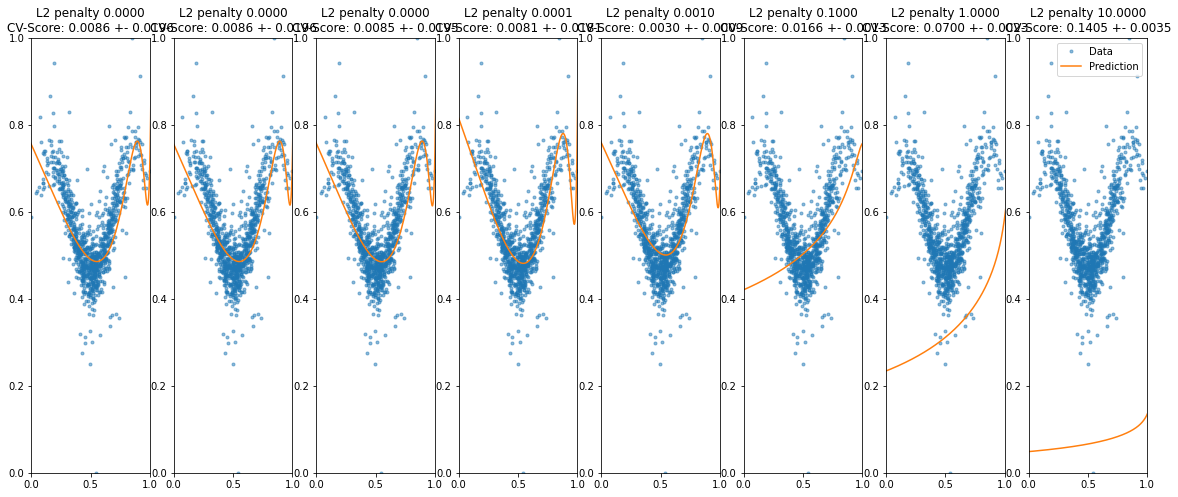

In [54]:
%%time
results = {}
row_results = {}
list_of_alpha = [0.00000000001, 0.000001, 0.00001, 0.0001, 0.001, 0.1, 1, 10]

for i,alpha in enumerate(list_of_alpha):
  ridge_regression = CustomRegression(loss_function=ridge, alpha=alpha) # create instance of model

  # make pipeline as list of pairs (<stage name>, <stage object>):
  pipeline = Pipeline([("ridge_regression", ridge_regression)]) # apply linear regression
  
  # from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
  pipeline.fit(X_a_train, y_train)

  # Evaluate pipeline using crossvalidation and score() method
  scores = cross_val_score(pipeline, X_a_train, y_train, cv=10)
  
  # Make single evaluation on test set
  #test_scores = pipeline.score(X_test, y_test)
  r_square = r2_score(y_test, pipeline.predict(X_a_test))  #I use R^2 to see how good model describe data

  # Save results
  results[alpha] = {'CV_mean':scores.mean(), 'CV_std':scores.std(), "R^2":r_square} #, 'Test':test_scores
  row_results[alpha] = scores

  # Plot results
  line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
  line_y = pipeline.predict(polynomial_features.fit_transform(line_x))
  
  ax = plt.subplot(1, len(list_of_alpha), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(line_x, line_y, '-', label = 'Prediction')
  plt.title("L2 penalty %.4f\nCV-Score: %.4f +- %.4f"%(alpha, 
                                                 results[alpha]['CV_mean'],
                                                 results[alpha]['CV_std']))
  
plt.legend()

In [55]:
results = pd.DataFrame(results).T
results.style.highlight_min()

,CV_mean,CV_std,R^2
1e-11,0.00855517,0.0196193,0.568144
1e-06,0.00855212,0.0196063,0.568472
1e-05,0.0085216,0.0194899,0.570976
0.0001,0.00813465,0.0180955,0.613391
0.001,0.00298591,0.000853901,0.579823
0.1,0.016559,0.00134214,-0.133326
1.0,0.0699649,0.00233,-5.04356
10.0,0.140541,0.00345758,-22.1685


Negative R^2 show that the model doesn't explain data

In [56]:
from sklearn.linear_model import Ridge

Wall time: 906 ms


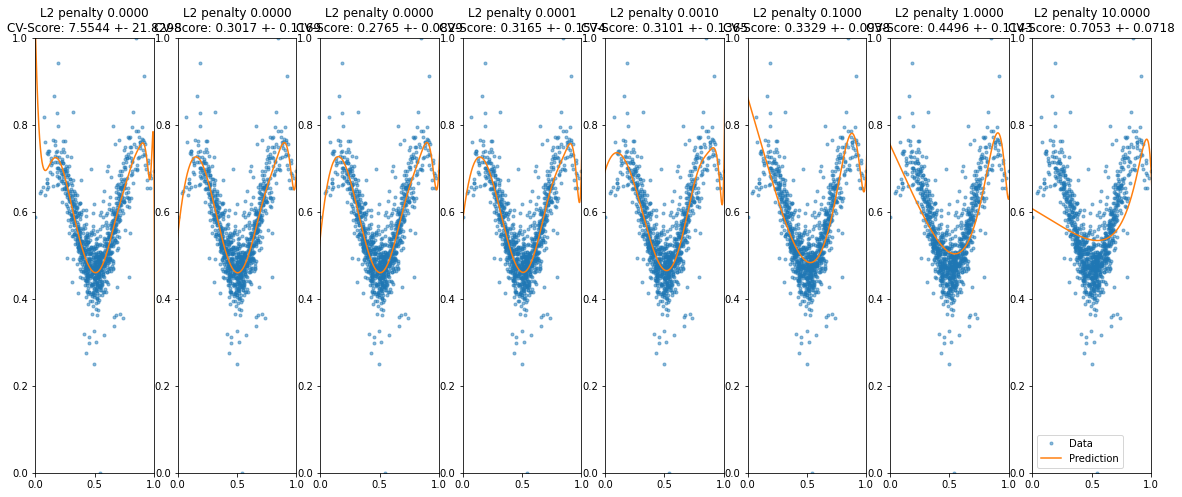

In [57]:
%%time
results = {}
row_results = {}
list_of_alpha = [0.00000000001, 0.000001, 0.00001, 0.0001, 0.001, 0.1, 1, 10]

for i,alpha in enumerate(list_of_alpha):
  ridge_regression = Ridge(alpha=alpha) # create instance of model

  # make pipeline as list of pairs (<stage name>, <stage object>):
  pipeline = Pipeline([("ridge_regression", ridge_regression)]) # apply linear regression
  
  # from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
  pipeline.fit(X_a_train, y_train)

  # Evaluate pipeline using crossvalidation and score() method
  scores = cross_val_score(pipeline, X_a_train, y_train, cv=10)
  
  # Make single evaluation on test set
  #test_scores = pipeline.score(X_test, y_test)

  # Save results
  results[alpha] = {'CV_mean': 1 - scores.mean(), 'CV_std':scores.std()} #, 'Test':test_scores
  row_results[alpha] = scores

  # Plot results
  line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
  line_y = pipeline.predict(polynomial_features.fit_transform(line_x))
  
  ax = plt.subplot(1, len(list_of_alpha), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(line_x, line_y, '-', label = 'Prediction')
  plt.title("L2 penalty %.4f\nCV-Score: %.4f +- %.4f"%(alpha, 
                                                 results[alpha]['CV_mean'],
                                                 results[alpha]['CV_std']))
  
plt.legend()

In [58]:
results = pd.DataFrame(results).T
results.style.highlight_min()

,CV_mean,CV_std
1e-11,7.55443,21.8298
1e-06,0.301686,0.11686
1e-05,0.276466,0.0829271
0.0001,0.316467,0.15744
0.001,0.310135,0.136486
0.1,0.332876,0.0937567
1.0,0.449575,0.114276
10.0,0.705335,0.0718009


### L1 regularization

In [59]:
#Define loss function for L1
def lasso(y_true, y_pred,X, x_i, theta, alpha):
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal" 
    return np.mean((y_true - y_pred)**2)/2 + alpha*np.sum(np.abs(theta))

In [60]:
n = 50
polynomial_features = PolynomialFeatures(degree=n,include_bias=True)
  
# make transformation of all data subsets
X_all = polynomial_features.fit_transform(X)
X_a_train = polynomial_features.fit_transform(X_train)
X_a_test = polynomial_features.fit_transform(X_test)

Wall time: 54.1 s


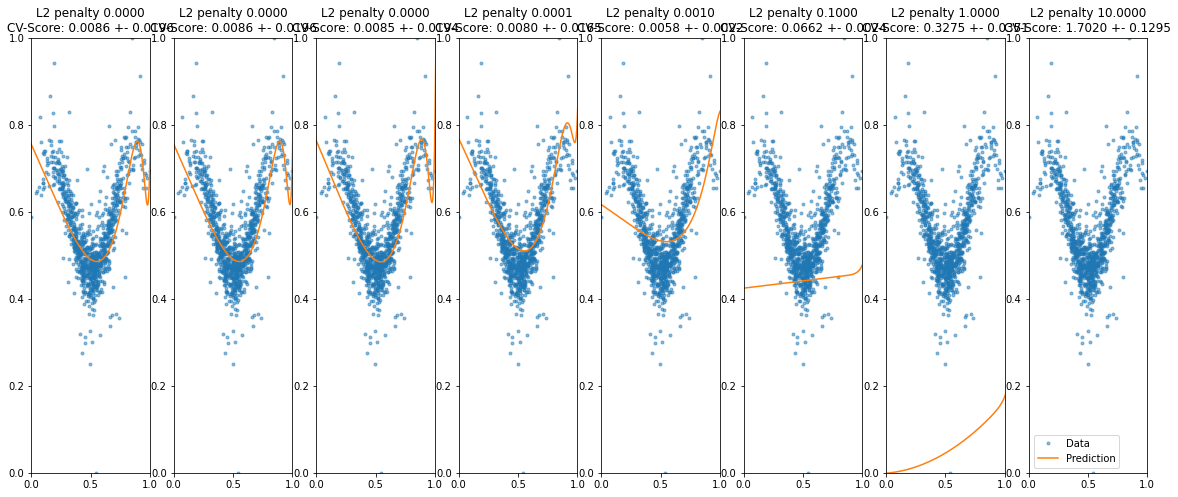

In [61]:
%%time
results = {}
row_results = {}
list_of_alpha = [0.00000000001, 0.000001, 0.00001, 0.0001, 0.001, 0.1, 1, 10]

for i,alpha in enumerate(list_of_alpha):
  ridge_regression = CustomRegression(loss_function=lasso, alpha=alpha) # create instance of model

  # make pipeline as list of pairs (<stage name>, <stage object>):
  pipeline = Pipeline([("ridge_regression", ridge_regression)]) # apply linear regression
  
  # from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
  pipeline.fit(X_a_train, y_train)

  # Evaluate pipeline using crossvalidation and score() method
  scores = cross_val_score(pipeline, X_a_train, y_train, cv=10)
  
  # Make single evaluation on test set
  #test_scores = pipeline.score(X_test, y_test)
  r_square = r2_score(y_test, pipeline.predict(X_a_test))

  # Save results
  results[alpha] = {'CV_mean':scores.mean(), 'CV_std':scores.std(), "R^2": 1 - r_square} #, 'Test':test_scores
  row_results[alpha] = scores

  # Plot results
  line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
  line_y = pipeline.predict(polynomial_features.fit_transform(line_x))
  
  ax = plt.subplot(1, len(list_of_alpha), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(line_x, line_y, '-', label = 'Prediction')
  plt.title("L2 penalty %.4f\nCV-Score: %.4f +- %.4f"%(alpha, 
                                                 results[alpha]['CV_mean'],
                                                 results[alpha]['CV_std']))
  
plt.legend()

In [62]:
results = pd.DataFrame(results).T
results.style.highlight_min()

,CV_mean,CV_std,R^2
1e-11,0.00855517,0.0196193,0.431856
1e-06,0.00855215,0.019594,0.43088
1e-05,0.00854101,0.0193506,0.41427
0.0001,0.0080443,0.0164868,0.448521
0.001,0.00581075,0.00221966,0.681503
0.1,0.0662272,0.00238677,2.12328
1.0,0.327526,0.0351193,24.837
10.0,1.70202,0.129537,41.1014


In [63]:
from sklearn.linear_model import Lasso

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7474311705913627, tolerance: 0.07194506816861253
  positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5636990743772152, tolerance: 0.0629838112240418
  positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6644081323002907, tolerance: 0.06386937420223184
  positive)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Wall time: 43.1 s


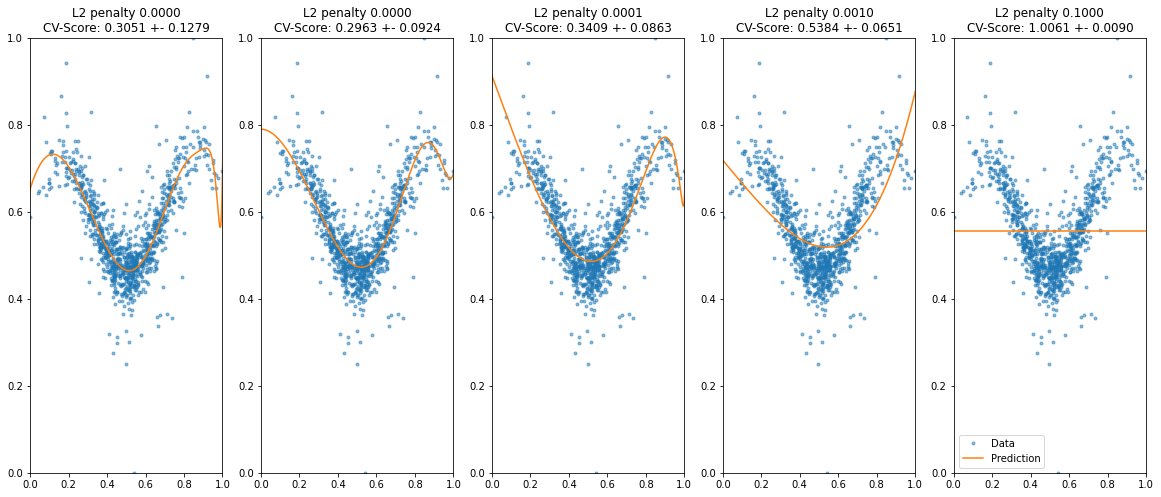

In [77]:
%%time
results = {}
row_results = {}
list_of_alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.1]

for i,alpha in enumerate(list_of_alpha):
  ridge_regression = Lasso(alpha=alpha, max_iter=10000, tol=0.01) # create instance of model

  # make pipeline as list of pairs (<stage name>, <stage object>):
  pipeline = Pipeline([("ridge_regression", ridge_regression)]) # apply linear regression
  
  # from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
  pipeline.fit(X_a_train, y_train)

  # Evaluate pipeline using crossvalidation and score() method
  scores = cross_val_score(pipeline, X_a_train, y_train, cv=10)
  
  # Make single evaluation on test set
  #test_scores = pipeline.score(X_test, y_test)

  # Save results
  results[alpha] = {'CV_mean': 1 - scores.mean(), 'CV_std':scores.std()} #, 'Test':test_scores
  row_results[alpha] = scores

  # Plot results
  line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
  line_y = pipeline.predict(polynomial_features.fit_transform(line_x))
  
  ax = plt.subplot(1, len(list_of_alpha), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(line_x, line_y, '-', label = 'Prediction')
  plt.title("L2 penalty %.4f\nCV-Score: %.4f +- %.4f"%(alpha, 
                                                 results[alpha]['CV_mean'],
                                                 results[alpha]['CV_std']))
  
plt.legend()

In [78]:
results = pd.DataFrame(results).T
results.style.highlight_min()

,CV_mean,CV_std
1e-06,0.305137,0.127949
1e-05,0.296271,0.0923645
0.0001,0.340945,0.0863445
0.001,0.538392,0.0650893
0.1,1.00606,0.00903096


## 2. Use regularization for to reduce number of features in polynomial regression 

In [73]:
n = 500
polynomial_features = PolynomialFeatures(degree=n,include_bias=True)
  
# make transformation of all data subsets
X_all = polynomial_features.fit_transform(X)
X_a_train = polynomial_features.fit_transform(X_train)
X_a_test = polynomial_features.fit_transform(X_test)

Wall time: 6.34 s


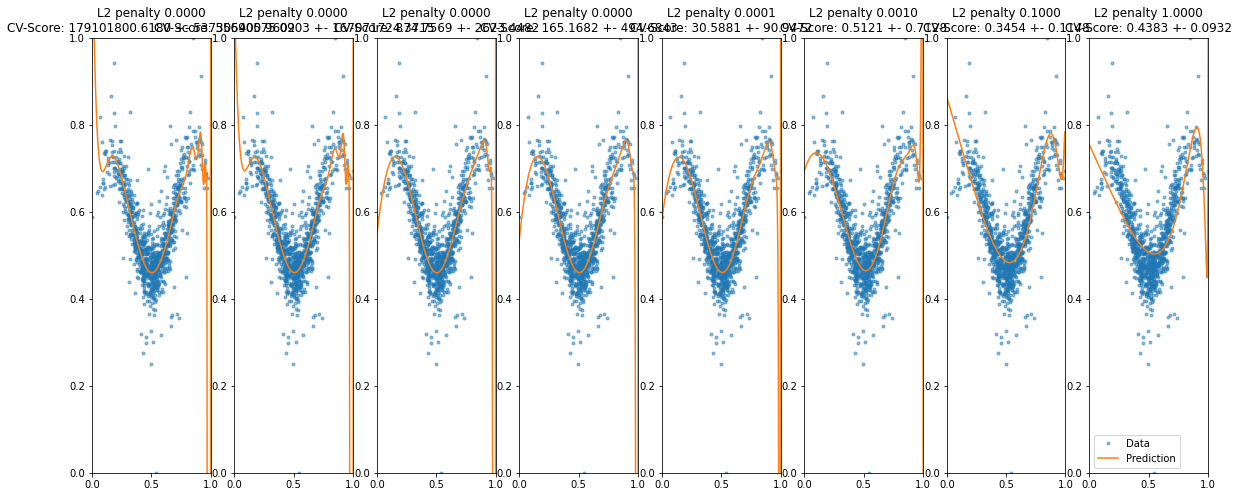

In [87]:
%%time
results = {}
row_results = {}
list_of_alpha = [0.000000000001, 0.00000000001, 0.000001, 0.00001, 0.0001, 0.001, 0.1, 1]

for i,alpha in enumerate(list_of_alpha):
  ridge_regression = Ridge(alpha=alpha) # create instance of model

  # make pipeline as list of pairs (<stage name>, <stage object>):
  pipeline = Pipeline([("ridge_regression", ridge_regression)]) # apply linear regression
  
  # from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
  pipeline.fit(X_a_train, y_train)

  # Evaluate pipeline using crossvalidation and score() method
  scores = cross_val_score(pipeline, X_a_train, y_train, cv=10)
  
  # Make single evaluation on test set
  #test_scores = pipeline.score(X_test, y_test)

  # Save results
  results[alpha] = {'CV_mean': 1 - scores.mean(), 'CV_std':scores.std()} #, 'Test':test_scores
  row_results[alpha] = scores

  # Plot results
  line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
  line_y = pipeline.predict(polynomial_features.fit_transform(line_x))
  
  ax = plt.subplot(1, len(list_of_alpha), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(line_x, line_y, '-', label = 'Prediction')
  plt.title("L2 penalty %.4f\nCV-Score: %.4f +- %.4f"%(alpha, 
                                                 results[alpha]['CV_mean'],
                                                 results[alpha]['CV_std']))
  
plt.legend()

In [88]:
results = pd.DataFrame(results).T
results.style.highlight_min()

,CV_mean,CV_std
1e-12,1.79102e+08,5.37305e+08
1e-11,5.56906e+07,1.67072e+08
1e-06,874.757,2623.45
1e-05,165.168,494.684
0.0001,30.5881,90.9472
0.001,0.512135,0.712796
0.1,0.345434,0.114756
1.0,0.438316,0.0932066


In [89]:
clf = Lasso(alpha=0.0000001) #Колонки, коэффициенты у которых больше выбраного нами значения, можно использовать для
clf.fit(X_a_train, y_train)  #построения модели 
print(np.sum(clf.coef_ > 0.01))

16


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.11718202679433, tolerance: 0.0007194506816861253
  positive)


## 3. Implement your own loss and objective function 

I implemented my own loss functions for l1, l2, classification

## 5. Remade the whole document to solve classification task 

In [33]:
#Define loss function for logistic regression
def logistic_regression(y_true, y_pred, X, theta, alpha):
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal" 
    return -np.mean(y_true*np.log(y_pred) + (1 - y_true)*np.log(1 - y_pred))

In [788]:
# Sigmoid 
def predict(X, theta):
    return 1/(1 + np.exp(-np.dot(X, theta)))

In [789]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

In [790]:
#Load Iris dataset
#Sorry, I was in hurry and used the most known dataset)
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

index = np.where(y_iris != 2)
X_iris = X_iris[index[0], :]
y_iris = y_iris[index[0]]

#Check the shape of data
print (X_iris.shape)
print (y_iris.shape)

(100, 4)
(100,)


In [791]:
#Standartised data for better optimization
scaler = StandardScaler()
scaler.fit_transform (X_iris,y_iris)
X_iris = scaler.transform (X_iris)

In [792]:
# Split data to test and train in sklearn style
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.33)

In [793]:
theta_init = np.ones_like(X_train_iris[0]) *  2 # initial value of theta
result = optimize.minimize(
                           objective_function,  # function to optimize. Parameter to optimize should the first argument 
                           args=(X_train_iris, y_train_iris, logistic_regression), # other arguments of the function
                           x0 = theta_init,     # initial value of parameter to optimize
                           method='L-BFGS-B',     # optimization method. Try also BFGS, Nelder-Mead, Powell, CG, TNC and others (see docs). Effectivnes can change dramatically!
                           options={}           # arguments of optimization method, like number of iterations, learning rate, etc.
                           )

print(result)

      fun: 1.2886286057641806e-05
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.01247305e-06,  5.81269702e-06, -6.45719592e-06, -7.63028912e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 75
      nit: 14
   status: 0
  success: True
        x: array([ 1.39034045, -3.64057569,  5.93780498,  6.89070312])


In [794]:
#Define loss function for logistic regression
def logistic_regression(y_true, y_pred, theta, alpha):
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal" 
    return -np.mean(y_true*np.log(y_pred) + (1 - y_true)*np.log(1 - y_pred))

logistic_regression = CustomRegression(loss_function=logistic_regression, 
                                       init = 2, iters=20, method='L-BFGS-B') # create instance of model
logistic_regression.fit(X_train_iris, y_train_iris)

prob = logistic_regression.predict(X_test_iris)
y_pred = [int(p>=0.5) for p in prob]

print("Coefficients:", logistic_regression.theta)
print("Accuracy_score:", accuracy_score(y_test_iris, y_pred))

Coefficients: [ 1.39034045 -3.64057569  5.93780498  6.89070312]
Accuracy_score: 1.0


In [783]:
from sklearn.linear_model import LogisticRegression

In [798]:
log_regr = LogisticRegression()

#Fit it for original data
log_regr.fit(X_train_iris, y_train_iris)
predict = log_regr.predict(X_test_iris)
z_o = accuracy_score(y_test_iris,predict)

print("Coefficients:", log_regr.intercept_, log_regr.coef_)
print("Accuracy_score:", z_o)

Coefficients: [0.14567083] [[ 0.73799858 -1.04692674  1.40999973  1.41616629]]
Accuracy_score: 1.0


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 4. Implement weighted linear regression and use cross-validation to find optimal $\sigma$ parameter

I wanted to find matrix theta by using optimization methods and don't use normal equation.\
Matrix theta has parameters [theta0, theta] for each x in data

In [161]:
def w(X, x_i, sigma):
    m = X.shape[0]
    return np.exp(- (X[:,1:] - x_i[1:])**2/(2*sigma**2))  #Use X[:,1:] because X[:,0] is column of 1 for intercept  

In [162]:
#Define loss function for locally weighted regression
def locally_weighted(y_true, y_pred, X, x_i, theta, sigma):
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal" 
    return 1/2*np.mean(w(X, x_i, sigma) * (y_pred - y_true)**2)

In [163]:
def objective_function_2(theta, X, y, x_i, loss_function=locally_weighted, alpha=None):
  y_true = np.asanyarray(y)
  y_pred = np.dot(w(X, x_i, alpha)*X, theta)                  #predict y using [theta0, theta1] from    
  return loss_function(y_true, y_pred, X, x_i, theta, alpha)  #array of thetas for each line 
                                                              #I find [theta0, theta1] for each line

In [164]:
def predict(X, theta, train_x): #Looking up for similar x in training data and use coeffs of x for estimation new data
    y = np.zeros(X.shape[0])
    for j in range(X.shape[0]):
        index_of_nearest_training_x = 0
        distance = np.linalg.norm(X[j] - train_x[0], ord=2)  #use norm for finding distance from point to point
        
        for i in range(len(train_x)):
            new_dist = np.linalg.norm(X[j] - train_x[i], ord=2)
            if distance > new_dist:
                distance = new_dist
                index_of_nearest_training_x = i
        
        y[j] = np.dot(X[j], theta[index_of_nearest_training_x])  #predict y using the nearest coefficients for x
    
    
    #y = np.zeros(X.shape[0])
    #for i in range(X.shape[0]):
    #    y[i] = np.dot(X[i], theta[i].T)
    return y

In [165]:
def fit(X, y, objective_function=objective_function_2, loss_function=locally_weighted,
        theta=None, iters=30, init=None, method='L-BFGS-B', alpha=0.05):

    if type(theta) == type(None):
        theta = np.array(np.ones_like(X))
    for i in range(X.shape[0]):            #searching for best parameters for every x
        x_i = X[i, :]

        theta[i] = custom_regression(X, y, x_i, objective_function=objective_function, 
                                   loss_function=loss_function, 
                                   init = theta[i], verbose = False, iters=iters, 
                                   method=method, alpha=alpha)

    return theta

In [166]:
def score(theta, X,y,loss_function, alpha, train_x=None):
    #return objective_function(theta=theta, X=X,y=y,loss_function=loss_function, alpha=alpha)
    y_pred = predict(X, theta, train_x)
    r_square = r2_score(y_pred, y)
    return r_square

In [183]:
#Initializing noisy non linear data
x = np.linspace(0,1,100)
x_1 = [[el] for el in x]
noise = np.random.normal(loc = 0, scale = .25, size = 100)
y = np.sin(x * 1.5 * np.pi ) #
y_noise = y + noise

sigma = 0.11
arr = np.stack((np.ones(len(x)), x), axis=1)

In [184]:
clf = CustomRegression(loss_function=locally_weighted, 
                       objective_function=objective_function_2,
                       alpha=sigma,
                       method='L-BFGS-B')
clf.fit(arr, y_noise)
y_pred = clf.predict(arr)
#clf.theta

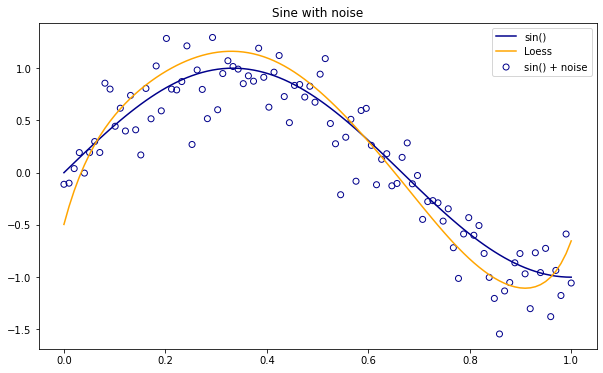

In [185]:
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'sin()')
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'sin() + noise')
plt.plot(x, y_pred, color = 'orange', label = 'Loess')
plt.legend()
plt.title('Sine with noise')
plt.show()